In [1]:
setwd("../../../")
source("codes/pathway/Stat_functions.R")
pacman::p_load(dplyr, ggplot2, tidyr, ComplexHeatmap, gridExtra, grid, stringr, ggsci)
options(stringsAsFactors = FALSE)

# Input

In [2]:
meta = read.csv("data/metadata/Metadata_061523.csv",row.names = 1)
subgroup_list = readRDS(file = "codes/correlation/Subgroup_sample_list.RDS")

In [3]:
abun=read.csv("data/metagenomics/Specie_abundance_filtered_90percent_maaslined.csv", row.names = 1)
immune=read.csv("data/immuno/immune_percentage.csv", row.names = 1)
bioc=read.csv("data/metabolomics/Metabolomics_masslined.csv", row.names = 1)

In [4]:
kegg=read.csv("data/metagenomics/KEGG_maaslined.csv", row.names = 1)

In [5]:
kegg_decode= read.csv("data/metagenomics/KEGG_decode.csv", header = T, row.names = 1)
kegg_decode = kegg_decode[rownames(kegg),]

In [6]:
abun_decode = read.csv("data/metagenomics/metaphlan4_species_full.csv", header = T, row.names = 1)
abun_decode = abun_decode[rownames(abun),c(1:7)]

In [7]:
bioc_decode = read.csv("data/metabolomics/QC-norm Data Common wImp_Jan_06_2022.csv", header = T, row.names = 1)
rownames(bioc_decode) = bioc_decode$CHEMICAL_NAME
bioc_decode = bioc_decode[rownames(bioc), c("SUPER_PATHWAY","SUB_PATHWAY")]

## Butanate pathway

In [8]:
pathway_annotation = read.csv("output/pathway/SCFA/Short_chain_fatty_acid_enzymes.csv")
rownames(pathway_annotation) = pathway_annotation$KO
pathway_annotation = pathway_annotation[pathway_annotation$pathway == 'butyrate_synthesis',]
target_ko = pathway_annotation$KO[pathway_annotation$KO %in% rownames(kegg)]
pathway_annotation = pathway_annotation[target_ko,]

In [9]:
kegg = kegg[target_ko,]

# Compute mean abundance in all groups

In [10]:
group_list = subgroup_list[c(2:length(subgroup_list))]
kegg_mean = calculate_mean(kegg, group_list)
kegg_fold = kegg_mean/kegg_mean$Healthy
kegg_p = calculate_p_vs_Healthy(kegg, group_list)

# Independent Cohort

In [11]:
ind_table = read.csv("data/indenpendent_cohorts/columbia/kegg_gene_normalized.csv", header = T, row.names = 1)
ind_table = ind_table[target_ko[target_ko %in% rownames(ind_table)],]

ind_decode = read.table("data/indenpendent_cohorts/columbia/SraRunTable.txt", sep = ",", 
                 header = T, row.names = 1)
ind_decode_list = list()
ind_decode_list$Healthy = colnames(ind_table)[ind_decode[colnames(ind_table),'sampletype'] == 'Control']
ind_decode_list$Patient = colnames(ind_table)[ind_decode[colnames(ind_table),'sampletype'] == 'Case']

In [12]:
guo_mean = calculate_mean(ind_table, ind_decode_list)
guo_fold = guo_mean/guo_mean$Healthy
guo_p = calculate_p_vs_Healthy(ind_table, ind_decode_list)

In [13]:
ind_table = read.csv("data/indenpendent_cohorts/Raijmakers/kegg_gene_normalized.csv", header = T, row.names = 1)
ind_table = ind_table[target_ko[target_ko %in% rownames(ind_table)],]
ind_table = ind_table[,!grepl('QFS', colnames(ind_table))]
ind_decode_list = list()
ind_decode_list$Healthy = colnames(ind_table)[grepl('HV', colnames(ind_table))]
ind_decode_list$Patient = colnames(ind_table)[grepl('CFS', colnames(ind_table))]

In [14]:
ruud_mean = calculate_mean(ind_table, ind_decode_list)
ruud_fold = ruud_mean/ruud_mean$Healthy
ruud_p = calculate_p_vs_Healthy(ind_table, ind_decode_list)

# Heatmap

In [15]:
group_names = c('Patient','Short','Long')
gene_names = target_ko

In [16]:
table_fold = cbind(kegg_fold[target_ko, group_names], 
                   guo_fold[target_ko, 'Patient'], 
                   ruud_fold[target_ko, 'Patient'])

table_p = cbind(kegg_p[target_ko, group_names], 
                guo_p[target_ko, 'Patient'], 
                ruud_p[target_ko, 'Patient'])
table_p = pvalue_table_adjust(table_p)

table_raw = cbind(kegg_mean[target_ko, group_names], 
                guo_mean[target_ko, 'Patient'], 
                ruud_mean[target_ko, 'Patient'])

colnames(table_fold) = c(group_names, 'Guo', 'Raijmakers')
colnames(table_p) = colnames(table_fold)
colnames(table_raw) = colnames(table_fold)
rownames(table_fold) = pathway_annotation[target_ko, 'enzyme']
rownames(table_fold) = str_split_fixed(rownames(table_fold), ",",2)[,1]
rownames(table_p) = rownames(table_fold)
rownames(table_raw) = rownames(table_fold)

Warning message:
“The input is a data frame-like object, convert it to a matrix.”
Warning message:
“The input is a data frame-like object, convert it to a matrix.”
Warning message:
“The input is a data frame-like object, convert it to a matrix.”


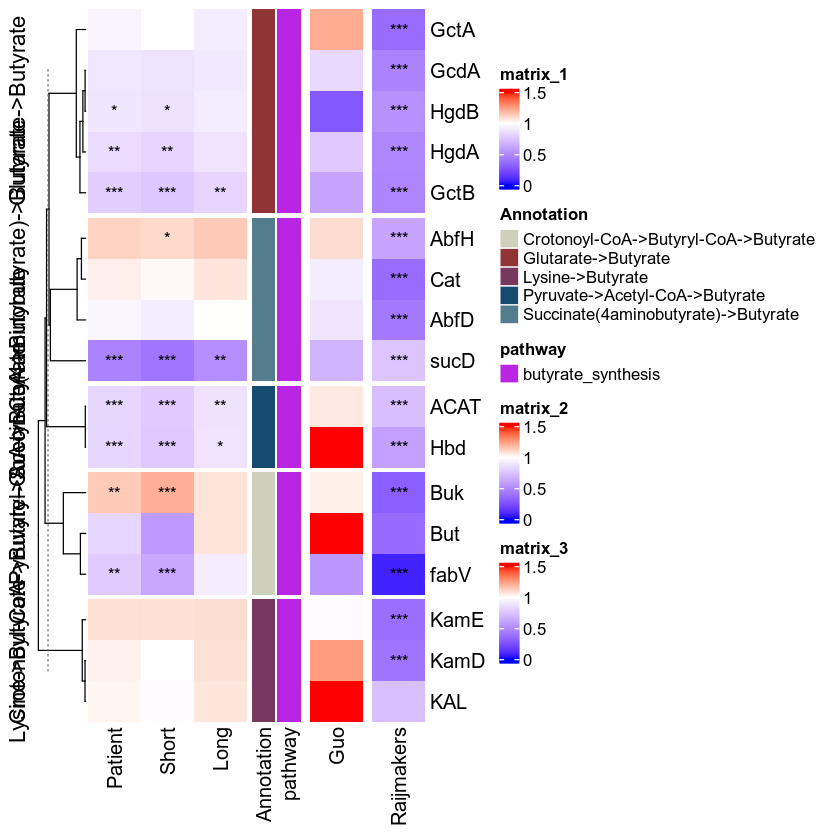

In [17]:
#pdf("output/pathway/SCFA/Heatmap.pdf", width = 10, height = 6)
col_fun= circlize::colorRamp2(c(0, 1, 1.5), c("blue", "white", "red"))
row_an = rowAnnotation(Annotation = pathway_annotation$Annotation,
                       pathway = pathway_annotation$pathway
                      )

heatmap_cols = group_names
heatmap_color = table_fold[ , heatmap_cols, drop = FALSE]
heatmap_text = table_p[,heatmap_cols, drop = FALSE]
heatmap_size = table_raw[,heatmap_cols, drop = FALSE]
heatmap_1 = Heatmap(heatmap_color, 
        cluster_columns = F, cluster_rows = T,
        row_split = pathway_annotation$Annotation,
        right_annotation=row_an,
        col = col_fun,
        cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf(heatmap_text[i, j]), x, y, gp = gpar(fontsize = 10))
        })

heatmap_cols = 'Guo'
heatmap_color = table_fold[ , heatmap_cols, drop = FALSE]
heatmap_text = table_p[,heatmap_cols, drop = FALSE]
heatmap_size = table_raw[,heatmap_cols, drop = FALSE]

heatmap_2 = Heatmap(heatmap_color, 
                    col = col_fun,
        cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf(heatmap_text[i, j]), x, y, gp = gpar(fontsize = 10))
        })

heatmap_cols = 'Raijmakers'
heatmap_color = table_fold[ , heatmap_cols, drop = FALSE]
heatmap_text = table_p[,heatmap_cols, drop = FALSE]
heatmap_size = table_raw[,heatmap_cols, drop = FALSE]

heatmap_3 = Heatmap(heatmap_color, 
        col = col_fun,
        cell_fun = function(j, i, x, y, width, height, fill) {
        grid.text(sprintf(heatmap_text[i, j]), x, y, gp = gpar(fontsize = 10))
        })

heatmap_1 + heatmap_2 + heatmap_3
#dev.off()

In [18]:
pdf("output/pathway/SCFA/Butyrate_Fold.pdf", width = 5, height = 6)
col_fun = circlize::colorRamp2(c(0.5, 1, 2), c("blue", "white", "red"))
size_fun = function(x, mag){log(x, base=20)/mag}
font_size = 20

annotation_col = 'Annotation'
annotation_text = pathway_annotation[,annotation_col]
annotation_text = factor(annotation_text, levels = (unique(annotation_text)))
annotation_catagory = unique(annotation_text)
annotation_colors = pal_npg()(length(annotation_catagory))
names(annotation_colors) = annotation_catagory
annotation_catagory_list = lapply(c(1:length(annotation_catagory)), 
                                  function(x) {annotation_catagory[x] %>% 
                                               str_replace_all("->", "->\n") %>% 
                                               str_replace_all("\\(", "\n(")})
names(annotation_catagory_list) = annotation_catagory                                           

module_colors = list(Module = annotation_colors)
row_an = rowAnnotation(textbox = anno_textbox(annotation_text, 
                                              annotation_catagory_list, 
                                              background_gp = gpar(fill = "transparent", 
                                                                   col = "transparent"),
                                              by = "anno_block",
                                              gp = gpar(fontsize = 18, col = "black"),
                                              side = "right", 
                                              just = "centre"),
                       Module = annotation_text, col = module_colors, 
                       annotation_name_rot = 45, annotation_name_gp = gpar(fontsize = 18),
                       show_legend = FALSE)
heatmap_cols = group_names
heatmap_color = table_fold[ , heatmap_cols, drop = FALSE]
heatmap_text = table_p[,heatmap_cols, drop = FALSE]
heatmap_size = table_raw[,heatmap_cols, drop = FALSE]
heatmap_1 = Heatmap(heatmap_color, 
        left_annotation = row_an, show_heatmap_legend=F,
        show_parent_dend_line = FALSE,row_title = NULL,border = TRUE,show_row_dend=F,
        row_split = annotation_text,
                    column_names_gp = gpar(fontsize = 18),column_names_rot = 45,
        cluster_columns = F, cluster_rows = F, rect_gp = gpar(type = "none"),
        cell_fun = function(j, i, x, y, width, height, fill) {
        grid.circle(x = x, y = y,
                    r = size_fun(heatmap_size[i, j],4.3)* min(unit.c(width, height)),
                    gp = gpar(fill = col_fun(heatmap_color[i, j]), col = 'lightgrey', lwd = 0.5));
        grid.text(sprintf(heatmap_text[i, j]), x, y, gp = gpar(fontsize = 15)) 
        })
heatmap_cols = "Guo"
heatmap_color = table_fold[ , heatmap_cols, drop = FALSE]
heatmap_text = table_p[,heatmap_cols, drop = FALSE]
heatmap_size = table_raw[,heatmap_cols, drop = FALSE]
heatmap_2 = Heatmap(heatmap_color, 
                    column_names_gp = gpar(fontsize = 18),column_names_rot = 45,
        rect_gp = gpar(type = "none"),show_heatmap_legend=F,
        cell_fun = function(j, i, x, y, width, height, fill) {
        grid.circle(x = x, y = y, 
                    r = size_fun(heatmap_size[i, j], 1)* min(unit.c(width, height)),
                    gp = gpar(fill = col_fun(heatmap_color[i, j]), col = 'lightgrey', lwd = 0.5));
        grid.text(sprintf(heatmap_text[i, j]), x, y, gp = gpar(fontsize = font_size)) 
        })
heatmap_cols = "Raijmakers"
heatmap_color = table_fold[ , heatmap_cols, drop = FALSE]
heatmap_text = table_p[,heatmap_cols, drop = FALSE]
heatmap_size = table_raw[,heatmap_cols, drop = FALSE]
heatmap_3 = Heatmap(heatmap_color, 
                    column_names_gp = gpar(fontsize = 18),column_names_rot = 45,
                    row_names_gp = gpar(fontsize = font_size),
       rect_gp = gpar(type = "none"),show_heatmap_legend=F,
        cell_fun = function(j, i, x, y, width, height, fill) {
        grid.circle(x = x, y = y, 
                    r = size_fun(heatmap_size[i, j], 3)* min(unit.c(width, height)),
                    gp = gpar(fill = col_fun(heatmap_color[i, j]), col = 'lightgrey', lwd = 0.5));
        grid.text(sprintf(heatmap_text[i, j]), x, y, gp = gpar(fontsize = 15)) 
        })
ht = heatmap_1 + heatmap_2 + heatmap_3
ht
dev.off()

pdf("output/pathway/SCFA/Module_legend.pdf", width = 4, height = 2)
par(mar = c(0, 0, 0, 0))
plot.new()
plot.window(xlim = c(0, 1), ylim = c(0, 1))
plot_square_with_label <- function(x, y, color, label) {
  rect(xleft = x - 0.05, ybottom = y, xright = x, ytop = y + 0.05, col = color, border = color)
  text(x, y + 0.025, label, pos = 4, cex = 0.8, adj = 0)
}
y_pos <- seq(0.9, by = -0.1, length.out = length(annotation_colors))
names_colors <- names(annotation_colors)
colors <- annotation_colors
for (i in seq_along(names_colors)) {
  plot_square_with_label(0.05, y_pos[i], colors[i], names_colors[i])
}
title(main = "Butyrate Module", adj = 0, line = -0.5, cex.main = 0.8)
dev.off()

Warning message:
“The input is a data frame-like object, convert it to a matrix.”
Warning message:
“The input is a data frame-like object, convert it to a matrix.”
Warning message:
“The input is a data frame-like object, convert it to a matrix.”


png 
  2

png 
  2

In [19]:
kegg_gene_order = row_order(ht)
kegg_gene_order = lapply(kegg_gene_order, function(x) target_ko[x])

Warning message:
“The heatmap list has not been initialized. You might have different
results if you repeatedly execute this function, e.g. when
row_km/column_km was set. It is more suggested to do as `ht_list =
draw(ht_list); row_order(ht_list)`.”


# Compute correlation in all groups

In [20]:
select_blood_responders = function(kegg, bioc, immune, group_list, path, cutoff = 5){
  # Intersect the column names of all three data frames to get common samples
  sample_all = Reduce(intersect, list(colnames(kegg), colnames(bioc), colnames(immune)))
  # Combine the data frames by rows after selecting common samples and transpose
  table_all = rbind(kegg[, sample_all], bioc[, sample_all], immune[, sample_all]) %>% t()
  
  corr_result = list()
  bioc_names = c()
  immune_names = c()
  
  for (name_i in names(group_list)){
    # Get samples for the current subgroup
    sample_i = sample_all[sample_all %in% group_list[[name_i]]]
    # Subset the combined table for the current samples
    combined = table_all[sample_i, ]
    # Calculate the Spearman correlation matrix
    combined_cor = cor(as.matrix(combined), method = "spearman")
    # Sum of absolute correlations for bioc markers
    bioc_cor = abs(colSums(combined_cor[rownames(kegg), rownames(bioc)]))
    # Sum of absolute correlations for immune markers
    immune_cor = abs(colSums(combined_cor[rownames(kegg), rownames(immune)]))
    
    # Apply different cutoff for 'Healthy_yr1'
    current_cutoff = if(name_i == 'Healthy_yr1') cutoff * 2 else cutoff
    
    bioc_name = names(sort(bioc_cor, decreasing = TRUE)[1:(current_cutoff/2)])
    immune_name = names(sort(immune_cor, decreasing = TRUE)[1:current_cutoff])
    
    bioc_names = c(bioc_names, bioc_name)  
    immune_names = c(immune_names, immune_name)  
    corr_result[[name_i]] = combined_cor[rownames(kegg), c(rownames(bioc), rownames(immune))]
  }
  
  bioc_names = unique(bioc_names)
  immune_names = unique(immune_names)
    
  bioc_decode = read.csv("data/metabolomics/QC-norm Data Common wImp_Jan_06_2022.csv", header = T, row.names = 1)
  rownames(bioc_decode) = bioc_decode$CHEMICAL_NAME
  bioc_decode = bioc_decode[bioc_names, c("SUPER_PATHWAY","SUB_PATHWAY")]

  # Select the correlations for the identified markers
  corr_result_select = lapply(corr_result, function(X) X[, c(bioc_names,immune_names)])
  
  # Write the results to CSV files
  lapply(names(corr_result_select), function(X) {
    #write.csv(corr_result_select[[X]], paste(path, X, "_sankey.csv", sep = ""))
  })
  
  decode = bioc_decode
  decode[immune_names,]=""  
  # Return the list of selected correlations
  return(list(corr_result = corr_result_select, decode = decode))
}


In [21]:
group_list = subgroup_list[c('Healthy_yr1','Short','Long')]
path = "output/pathway/SCFA/sankey/"
kegg_list = kegg_gene_order[c(1:4)] %>% unlist()
corr_result_list = select_blood_responders(kegg[kegg_list,],
                                      bioc, immune, group_list, path, cutoff = 10)
corr_result = corr_result_list$corr_result
decode = corr_result_list$decode

In [22]:
pdf("output/pathway/SCFA/sankey/blood_correlation_heatmap.pdf", width = 10, height = 10)
Healthy_yr1 = Heatmap(corr_result$Healthy_yr1 %>% t(), 
                      column_order=kegg_list,
                      column_split = pathway_annotation[kegg_list,'Annotation'],
                      show_heatmap_legend=F)
Short = Heatmap(corr_result$Short %>% t(), 
                column_order=kegg_list,
                column_split = pathway_annotation[kegg_list,'Annotation'],
                show_heatmap_legend=F)
Long = Heatmap(corr_result$Long %>% t(), 
                              column_order=kegg_list,
                column_split = pathway_annotation[kegg_list,'Annotation'],
               show_heatmap_legend=F)
Healthy_yr1 + Short + Long

write.csv(decode[row_order(Healthy_yr1),], paste(path, "blood_responder_decode.csv", sep = ""))
dev.off()

png 
  2

# Annotate

In [23]:
group_list = subgroup_list[c('Healthy_yr1','Short','Long')]
path = "output/pathway/SCFA/sankey/"
kegg_list = kegg_gene_order %>% unlist()
corr_result_list = select_blood_responders(kegg[kegg_list,], bioc, immune, group_list, path, cutoff = 50)
corr_result = corr_result_list$corr_result

In [24]:
blood_responder_decode <- read.csv(paste(path, "blood_responder_decode.csv", sep = ""), 
                                     header = TRUE, row.names = 1)
responders <- rownames(blood_responder_decode)[blood_responder_decode$Annotation != ""]
blood_responder_decode = blood_responder_decode[responders,]

In [25]:
lapply(names(corr_result), function(X) {
    write.csv(corr_result[[X]][kegg_list, responders], paste(path, X, "_sankey.csv", sep = ""))
})

[[1]]
NULL

[[2]]
NULL

[[3]]
NULL

In [26]:
pathway_annotation = pathway_annotation[kegg_list,]
pathway_annotation$Color = annotation_colors[pathway_annotation$Annotation]
write.csv(pathway_annotation[kegg_list, c('Annotation','Color')], paste(path, "kegg_decode_sankey.csv", sep = ""))

In [27]:
annotation_catagory = unique(blood_responder_decode[,'Annotation'])
annotation_colors = pal_simpsons()(length(annotation_catagory))
names(annotation_colors) = annotation_catagory
blood_responder_decode$Color = annotation_colors[blood_responder_decode$Annotation]
write.csv(blood_responder_decode[responders, 
                                 c('Annotation','Color')], paste(path, "responder_decode_sankey.csv", sep = ""))

# Plot the fold changes of blood responders

In [28]:
sample_all = Reduce(intersect, list(colnames(kegg), colnames(bioc), colnames(immune)))
table_all = rbind(kegg[, sample_all], bioc[, sample_all], immune[, sample_all])

In [29]:
blood_responder_table = table_all[rownames(blood_responder_decode),]
blood_responder_mean = calculate_mean(blood_responder_table, 
                                      subgroup_list[c('Healthy','Patient','Short','Long')])
blood_responder_p = calculate_p_vs_Healthy(blood_responder_table, 
                                           subgroup_list[c('Healthy','Patient','Short','Long')])
blood_responder_p = pvalue_table_adjust(blood_responder_p)
blood_responder_fold = blood_responder_mean/blood_responder_mean$Healthy
blood_responder_raw = blood_responder_mean

In [30]:
rownames_clean = gsub("%", "", gsub("d[016]", "", gsub(" ", "", gsub("\\([^\\)]+\\)", "", 
                                                                      rownames(blood_responder_p)))))
rownames_clean = make.unique(rownames_clean, sep = "")

In [31]:
rownames(blood_responder_p) = rownames_clean
rownames(blood_responder_fold) = rownames_clean
rownames(blood_responder_raw) = rownames_clean
rownames(blood_responder_decode) = rownames_clean

In [32]:
pdf("output/pathway/SCFA/Blood_Responder_Fold.pdf", width = 5.5, height = 6)
col_fun = circlize::colorRamp2(c(0.5, 1, 2), c("blue", "white", "red"))
size_fun = function(x, mag){log(x, base=5)/mag}
font_size = 20

annotation_col = 'Annotation'
annotation_text = blood_responder_decode[,annotation_col]
annotation_text = factor(annotation_text, levels = (unique(annotation_text)))
annotation_catagory = unique(annotation_text)
annotation_colors = pal_simpsons()(length(annotation_catagory))
names(annotation_colors) = annotation_catagory
annotation_catagory_list = lapply(c(1:length(annotation_catagory)), 
                                  function(x) {annotation_catagory[x] %>% 
                                               str_replace_all("\\/", "/\n")})
names(annotation_catagory_list) = annotation_catagory                                           

module_colors = list(Module = annotation_colors)
row_an = rowAnnotation(Module = annotation_text, col = module_colors, 
                       textbox = anno_textbox(annotation_text, 
                                              annotation_catagory_list, 
                                              background_gp = gpar(fill = "transparent", 
                                                                   col = "transparent"),
                                              by = "anno_block",
                                              gp = gpar(fontsize = 20, col = "black"),
                                              side = "right", 
                                              just = "centre"),
                       annotation_name_rot = 45, annotation_name_gp = gpar(fontsize = 18),
                       show_legend = FALSE)
heatmap_cols = group_names
heatmap_color = blood_responder_fold[ , heatmap_cols, drop = FALSE]
heatmap_text = blood_responder_p[,heatmap_cols, drop = FALSE]
heatmap_size = blood_responder_raw[,heatmap_cols, drop = FALSE]
heatmap_1 = Heatmap(heatmap_color, 
        right_annotation = row_an, show_heatmap_legend=F,
        show_parent_dend_line = FALSE,row_title = NULL,border = TRUE,show_row_dend=F,
        row_split = annotation_text,row_names_side = "left",
        column_names_gp = gpar(fontsize = 18),column_names_rot = 45,
        cluster_columns = F, cluster_rows = F, rect_gp = gpar(type = "none"),
        cell_fun = function(j, i, x, y, width, height, fill) {
        grid.circle(x = x, y = y,
                    r = size_fun(heatmap_size[i, j],4.5)* min(unit.c(width, height)),
                    gp = gpar(fill = col_fun(heatmap_color[i, j]), col = 'lightgrey', lwd = 0.5));
        grid.text(sprintf(heatmap_text[i, j]), x, y, gp = gpar(fontsize = 13)) 
        })

heatmap_1
dev.off()

pdf("output/pathway/SCFA/Respondor_legend.pdf", width = 4, height = 2)
par(mar = c(0, 0, 0, 0))
plot.new()
plot.window(xlim = c(0, 1), ylim = c(0, 1))
plot_square_with_label <- function(x, y, color, label) {
  rect(xleft = x - 0.05, ybottom = y, xright = x, ytop = y + 0.05, col = color, border = color)
  text(x, y + 0.025, label, pos = 4, cex = 0.8, adj = 0)
}
y_pos <- seq(0.9, by = -0.1, length.out = length(annotation_colors))
names_colors <- names(annotation_colors)
colors <- annotation_colors
for (i in seq_along(names_colors)) {
  plot_square_with_label(0.05, y_pos[i], colors[i], names_colors[i])
}
title(main = "Butyrate Blood Responder", adj = 0, line = -0.5, cex.main = 0.8)
dev.off()

Warning message:
“The input is a data frame-like object, convert it to a matrix.”


png 
  2

png 
  2